In [1]:
# %load_ext autoreload
# %autoreload 2

# import sys
# sys.path.append('..')

In [141]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from scipy.stats import pearsonr

from lib import obs
from lib.plotting import maps

In [3]:
sfo = obs.daily_summary('SFO', '1990-07-01', '2021-06-01')

In [4]:
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

In [20]:
data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f']

sfo_monthly = sfo[data_cols].resample('M', on='day').agg({
    'precip_in': np.sum,
    'max_temp_f': np.mean,
    'min_temp_f': np.mean
}).reset_index()


sfo_monthly['mean_temp'] = (sfo_monthly.max_temp_f + sfo_monthly.min_temp_f) / 2
sfo_djf = sfo_monthly[sfo_monthly.day.dt.month.isin([12, 1, 2])]

mean_all_temps = sfo_djf.mean_temp.mean()
sd_all_temps = sfo_djf.mean_temp.std()
mean_all_precip = sfo_djf.precip_in.mean()
sd_all_precip = sfo_djf.precip_in.std()

sfo_djf['temp_anom'] = sfo_djf.mean_temp - mean_all_temps
sfo_djf['precip_anom'] = sfo_djf.precip_in - mean_all_precip

sfo_djf['temp_anom_std'] = sfo_djf.temp_anom / sd_all_temps
sfo_djf['precip_anom_std'] = sfo_djf.precip_anom / sd_all_precip

<ipython-input-20-68e35875a2cd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_djf['temp_anom'] = sfo_djf.mean_temp - mean_all_temps
<ipython-input-20-68e35875a2cd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfo_djf['precip_anom'] = sfo_djf.precip_in - mean_all_precip
<ipython-input-20-68e35875a2cd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [22]:
sfo_djf

,day,precip_in,max_temp_f,min_temp_f,mean_temp,temp_anom,precip_anom,temp_anom_std,precip_anom_std
5,1990-12-31,1.71,53.741935,39.258065,46.500000,-5.361960,-2.046344,-2.326936,-0.676183
6,1991-01-31,0.20,57.064516,43.161290,50.112903,-1.749056,-3.556344,-0.759040,-1.175139
7,1991-02-28,3.76,62.214286,48.178571,55.196429,3.334469,0.003656,1.447064,0.001208
17,1991-12-31,2.62,57.387097,44.064516,50.725806,-1.136153,-1.136344,-0.493058,-0.375487
18,1992-01-31,1.94,54.774194,42.774194,48.774194,-3.087766,-1.816344,-1.340002,-0.600183
...,...,...,...,...,...,...,...,...,...
354,2020-01-31,1.04,58.290323,46.000000,52.145161,0.283202,-2.716344,0.122901,-0.897574
355,2020-02-29,0.00,64.551724,46.137931,55.344828,3.482868,-3.756344,1.511464,-1.241226
365,2020-12-31,1.28,61.096774,45.419355,53.258065,1.396105,-2.476344,0.605869,-0.818270
366,2021-01-31,2.83,59.967742,46.580645,53.274194,1.412234,-0.926344,0.612869,-0.306096


In [40]:
cold_wet = sfo_djf[(sfo_djf.temp_anom_std < -0.25) & (sfo_djf.precip_anom_std > 0.25)]
cold_wet

,day,precip_in,max_temp_f,min_temp_f,mean_temp,temp_anom,precip_anom,temp_anom_std,precip_anom_std
29,1992-12-31,5.92,55.193548,44.064516,49.629032,-2.232927,2.163656,-0.969026,0.714947
30,1993-01-31,11.07,55.225806,42.967742,49.096774,-2.765185,7.313656,-1.200011,2.416685
43,1994-02-28,5.12,56.535714,44.464286,50.500000,-1.361960,1.363656,-0.591051,0.450599
78,1997-01-31,7.35,55.129032,46.322581,50.725806,-1.136153,3.593656,-0.493058,1.187468
127,2001-02-28,5.98,56.428571,45.035714,50.732143,-1.129817,2.223656,-0.490308,0.734773
210,2008-01-31,9.87,53.036774,43.682581,48.359677,-3.502282,6.113656,-1.519890,2.020163
234,2010-01-31,5.94,55.645161,46.838710,51.241935,-0.620024,2.183656,-0.269073,0.721555
247,2011-02-28,4.79,58.178571,43.000000,50.589286,-1.272674,1.033656,-0.552304,0.341556
318,2017-01-31,9.19,56.451613,43.709677,50.080645,-1.781314,5.433656,-0.773039,1.795468
343,2019-02-28,7.20,55.892857,44.071429,49.982143,-1.879817,3.443656,-0.815786,1.137903


In [126]:
warm_wet = sfo_djf[(sfo_djf.temp_anom_std > 0.25) & (sfo_djf.precip_anom_std > 0.25)]
warm_wet

,day,precip_in,max_temp_f,min_temp_f,mean_temp,temp_anom,precip_anom,temp_anom_std,precip_anom_std
19,1992-02-29,6.22,62.655172,49.275862,55.965517,4.103558,2.463656,1.780826,0.814077
31,1993-02-28,4.54,58.107143,47.071429,52.589286,0.727326,0.783656,0.315639,0.258947
65,1995-12-31,6.27,58.580645,48.806452,53.693548,1.831589,2.513656,0.794857,0.830599
67,1996-02-29,5.75,60.310345,49.172414,54.741379,2.879420,1.993656,1.249585,0.658773
77,1996-12-31,6.49,58.870968,49.290323,54.080645,2.218686,2.733656,0.962846,0.903294
90,1998-01-31,7.77,57.290323,48.516129,52.903226,1.041266,4.013656,0.451880,1.326251
114,2000-01-31,5.65,57.451613,47.677419,52.564516,0.702557,1.893656,0.304889,0.625729
115,2000-02-29,8.15,57.827586,48.793103,53.310345,1.448385,4.393656,0.628558,1.451816
149,2002-12-31,9.37,57.774194,47.612903,52.693548,0.831589,5.613656,0.360886,1.854946
175,2005-02-28,4.82,60.357143,49.571429,54.964286,3.102326,1.063656,1.346320,0.351469


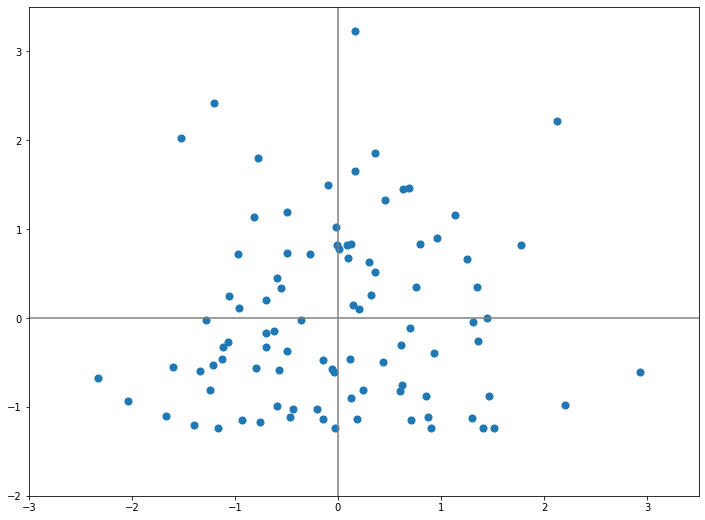

In [31]:
plt.figure(figsize=(12, 9))
plt.scatter(sfo_djf.temp_anom_std, sfo_djf.precip_anom_std, s=50)
plt.ylim([-2, 3.5])
plt.xlim([-3, 3.5])
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

In [142]:
pearsonr(sfo_djf.temp_anom_std, sfo_djf.precip_anom_std)

(0.06205469716710568, 0.5545806558540495)

In [88]:
ds_mon = xr.open_dataset('hgt.mon.mean.nc')
ds_mon_mean = xr.open_dataset('hgt.mon.ltm.nc')

def coerce_ltm_ds(ds, years):
    orig_times = ds.time.values
    concat_datasets = []
    for year in years:
        ds_for_year = ds.copy()
        newtimes = np.array([pd.Timestamp(year=year,
                                          month=t.month,
                                          day=t.day,
                                          hour=t.hour,
                                          minute=t.minute) for t in orig_times])
        ds_for_year['time'] = newtimes
        concat_datasets.append(ds_for_year)
        
    return xr.concat(concat_datasets, dim='time')

ds_mon_mean = coerce_ltm_ds(ds_mon_mean, range(1970, 2022))

west, east, north, south = 0, 360, 90, 10
months = [12, 1, 2]

kw = {}
kw['lon'] = slice(west, east)
kw['lat'] = slice(north, south)
kw['level'] = 500

hgt = ds_mon.sel(**kw)
hgt_mean = ds_mon_mean.sel(**kw)
hgt_anom = hgt - hgt_mean

hgt_anom_djf = hgt_anom.sel(time=np.in1d(hgt_anom['time.month'], months))

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:463: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/coding/times.py:83: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/xarray/core/indexing.py:568: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continu

In [89]:
hgt_anom_djf

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 144, time: 155)
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-02-01
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... 20.0 17.5 15.0 12.5 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    hgt      (time, lat, lon) float32 83.79 83.79 83.79 ... 7.136 7.274 6.623

In [90]:
cold_wet_days = cold_wet.day - pd.offsets.MonthBegin(1, normalize=True)
cold_wet_q = (hgt_anom_djf.time.isin(cold_wet_days)) 

cold_wet_ds = hgt_anom_djf.where(cold_wet_q, drop=True)
cold_wet_ds

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 144, time: 10)
Coordinates:
  * time     (time) datetime64[ns] 1992-12-01 1993-01-01 ... 2019-02-01
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... 20.0 17.5 15.0 12.5 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    hgt      (time, lat, lon) float32 -62.89 -62.89 -62.89 ... 18.01 18.96 19.62

In [91]:
cold_wet_da = cold_wet_ds.hgt.mean(dim='time')
cold_wet_da

<xarray.DataArray 'hgt' (lat: 33, lon: 144)>
array([[-61.445606  , -61.445606  , -61.445606  , ..., -61.445606  ,
        -61.445606  , -61.445606  ],
       [-53.72051   , -53.803123  , -53.88369   , ..., -53.499805  ,
        -53.558205  , -53.621876  ],
       [-42.09077   , -42.017628  , -41.98716   , ..., -42.278954  ,
        -42.205128  , -42.129784  ],
       ...,
       [ -3.7228026 ,  -3.8221679 ,  -3.7922852 , ...,  -1.2895508 ,
         -2.3894043 ,  -3.240869  ],
       [ -0.7200195 ,  -0.8121582 ,  -0.91489255, ...,   0.28671876,
         -0.15991211,  -0.5145508 ],
       [  1.1809571 ,   1.0706543 ,   0.98896486, ...,   1.3633789 ,
          1.237793  ,   1.2322266 ]], dtype=float32)
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... 20.0 17.5 15.0 12.5 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

Text(0.5, 1.0, 'Cold-Wet SFO months in DJF 1990-2021 | by Jim Tang (@wxmann)')

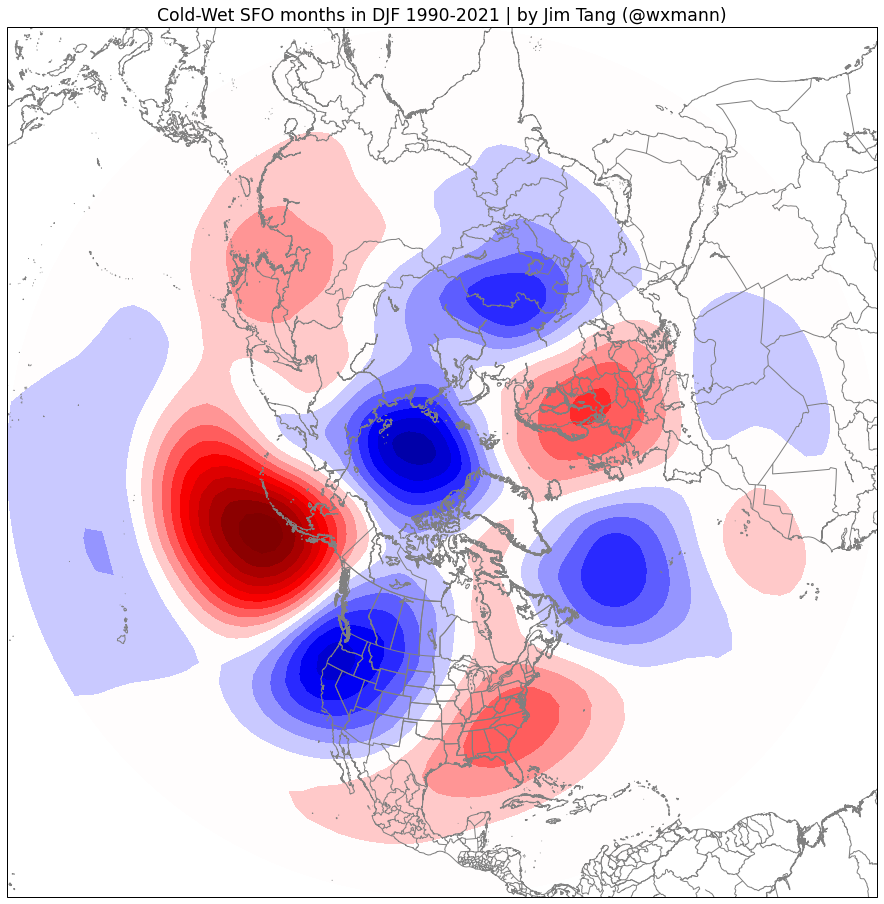

In [140]:
plt.figure(figsize=(16, 16))

proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
m = maps.CartopyMap(proj=proj)
m.draw()

lons = cold_wet_da.lon
lats = cold_wet_da.lat
data = cold_wet_da.values
data, lons = add_cyclic_point(data, coord=lons)

lons, lats = np.meshgrid(lons, lats)
data = np.reshape(data, lons.shape)

m.ax.contourf(lons, lats, data,
             transform=ccrs.PlateCarree(), cmap='seismic', 
              levels=np.arange(-95, 105, 10), extend='both')

plt.title('Cold-Wet SFO months in DJF 1990-2021 | by Jim Tang (@wxmann)', size='xx-large')

In [127]:
warm_wet_days = warm_wet.day - pd.offsets.MonthBegin(1, normalize=True)
warm_wet_q = (hgt_anom_djf.time.isin(warm_wet_days)) 

warm_wet_ds = hgt_anom_djf.where(warm_wet_q, drop=True)
warm_wet_ds

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 144, time: 15)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-01 1993-02-01 ... 2018-01-01
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... 20.0 17.5 15.0 12.5 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    hgt      (time, lat, lon) float32 -18.97 -18.97 -18.97 ... 9.055 8.647 8.58

In [128]:
warm_wet_da = warm_wet_ds.hgt.mean(dim='time')
warm_wet_da

<xarray.DataArray 'hgt' (lat: 33, lon: 144)>
array([[20.015852 , 20.015852 , 20.015852 , ..., 20.015852 , 20.015852 ,
        20.015852 ],
       [23.53073  , 23.455534 , 23.34463  , ..., 23.769173 , 23.698763 ,
        23.626759 ],
       [26.293913 , 26.12194  , 25.938509 , ..., 26.805534 , 26.649641 ,
        26.459505 ],
       ...,
       [ 4.731087 ,  5.388444 ,  5.8552084, ...,  2.3738606,  3.197884 ,
         3.9772787],
       [ 4.104427 ,  4.5211263,  4.9586263, ...,  2.6661785,  3.2262044,
         3.68584  ],
       [ 3.6726236,  3.9577475,  4.341439 , ...,  2.7813802,  3.2073894,
         3.5055013]], dtype=float32)
Coordinates:
    level    float32 500.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... 20.0 17.5 15.0 12.5 10.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


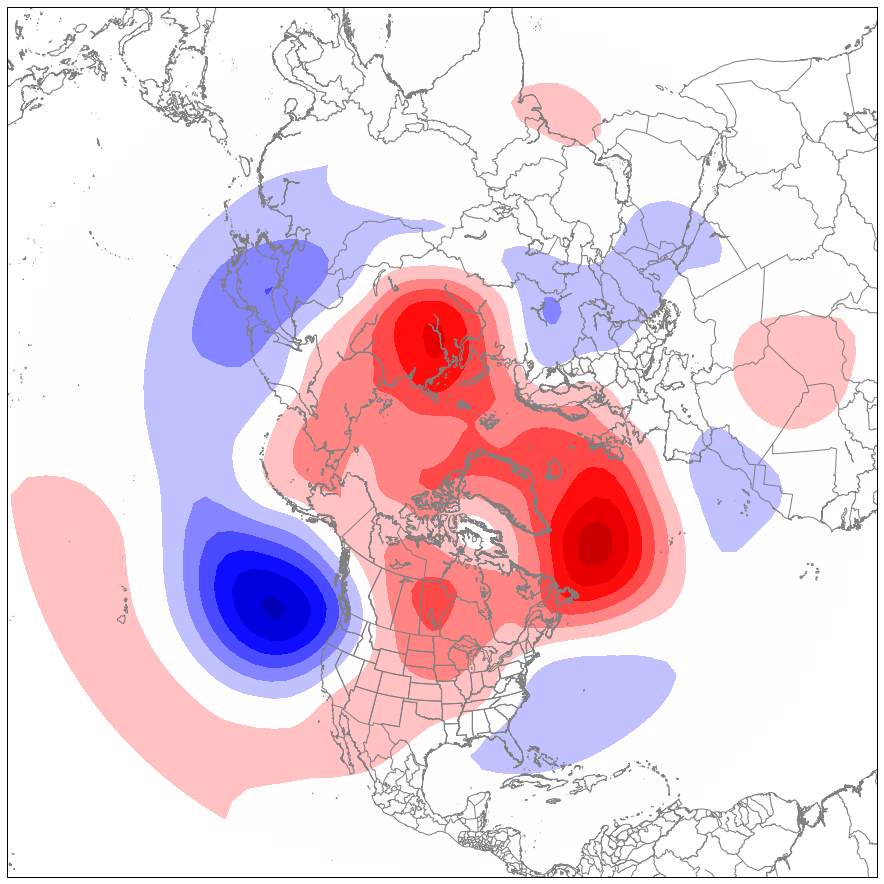

In [129]:
plt.figure(figsize=(16, 16))

proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
m = maps.CartopyMap(proj=proj)
m.draw()

lons = warm_wet_da.lon
lats = warm_wet_da.lat
data = warm_wet_da.values
data, lons = add_cyclic_point(data, coord=lons)

lons, lats = np.meshgrid(lons, lats)
data = np.reshape(data, lons.shape)

m.ax.contourf(lons, lats, data,
             transform=ccrs.PlateCarree(), cmap='seismic', 
              levels=np.arange(-85, 95, 10), extend='both')